# Example: Linear Kinematic Car Filtering

This example concerns simulation and filtering of the linear double-integrator system representing a kinematic car defined in `linear_car_system.py`:

$$\text{state: } x = \begin{bmatrix}\text{pos} \\ \text{vel}\end{bmatrix} \quad \text{control: } u = \begin{bmatrix}\text{acc}\end{bmatrix}$$
$$A = \begin{bmatrix}
    1 & \Delta t \\
    0 & 1
\end{bmatrix} \quad B = \begin{bmatrix}(\Delta t)^2/2 \\ \Delta t\end{bmatrix} \quad C = \begin{bmatrix}1 & 0\end{bmatrix}$$
$$f(x, u, w) = Ax + Bu + w$$
$$h(x, v) = Cx + v$$
$$w \sim \mathcal{N}(0, R) \quad v \sim \mathcal{N}(0, Q)$$

In [10]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [11]:
import sys; sys.path.append("../../")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ground-Truth Simulation

In [12]:
# Prepare the simulation

from linear_car_system import linear_car_system as car_system_gt

timesteps = np.arange(0.0, 15.0, step=car_system_gt.delta_t)
T = len(timesteps)

states_gt = np.zeros((T, 2, 1))
controls = np.zeros((T, 1, 1))
measurements = np.zeros((T, 1, 1))

# initial position and velocity
states_gt[0] = np.vstack([0, 0])

# acceleration schedule
controls[10:50] = np.vstack([0.5])
controls[50:90] = np.vstack([-0.5])

In [13]:
# Run the simulation

np.random.seed(1337)    # seed for repeatability

for t in tqdm(range(1, T)):
    x = states_gt[t-1]
    u = controls[t]

    x_next = car_system_gt.query_dynamics_model(x, u)
    states_gt[t] = x_next

    z = car_system_gt.query_measurement_model(x_next)
    measurements[t] = z

100%|██████████| 149/149 [00:00<00:00, 8618.23it/s]


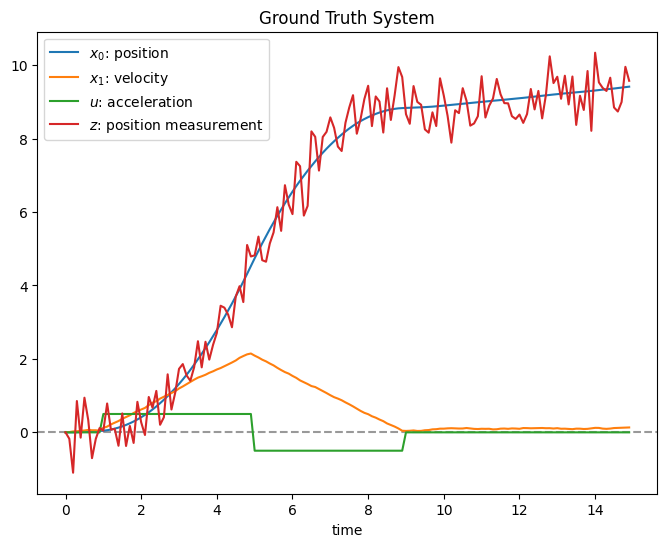

In [14]:
# Plot simulation results

plt.figure(figsize=(8, 6))
plt.title("Ground Truth System")
plt.xlabel("time")
plt.axhline(0, linestyle="--", color="gray", alpha=0.8)
plt.plot(timesteps, states_gt[:,0], label="$x_0$: position")
plt.plot(timesteps, states_gt[:,1], label="$x_1$: velocity")
plt.plot(timesteps, controls[:,0], label="$u$: acceleration")
plt.plot(timesteps, measurements[:,0], label="$z$: position measurement")
plt.legend()

## State Estimation: Kalman Filter

In [15]:
# Prepare filter

from estimation_and_control.filters import KalmanFilter

# define the approximate system model to be used by the filter
# (in this case, our model has no mismatch with ground-truth system)
car_system_model = car_system_gt

car_filter = KalmanFilter(car_system_model)

# initial state belief
car_filter.initialize(
    np.random.normal(0, 2, size=(2, 1)),      # initial mean (random)
    np.array([ [0.5, 0.0],                    # initial covariance
               [0.0, 0.5] ])
)

In [16]:
# Run the filter

means_KF = np.zeros((T, 2, 1))
covariances_KF = np.zeros((T, 2, 2))

means_KF[0] = car_filter.mean
covariances_KF[0] = car_filter.covariance


for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    car_filter.predict_step(u)
    car_filter.update_step(z)

    means_KF[t] = car_filter.mean
    covariances_KF[t] = car_filter.covariance

100%|██████████| 149/149 [00:00<00:00, 18560.52it/s]


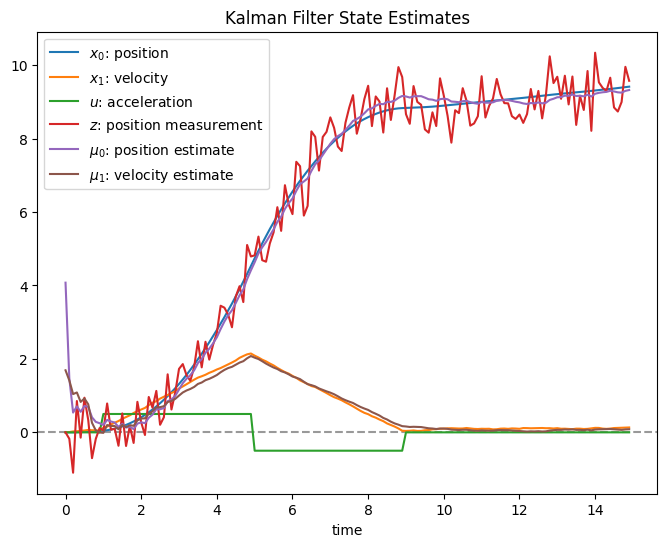

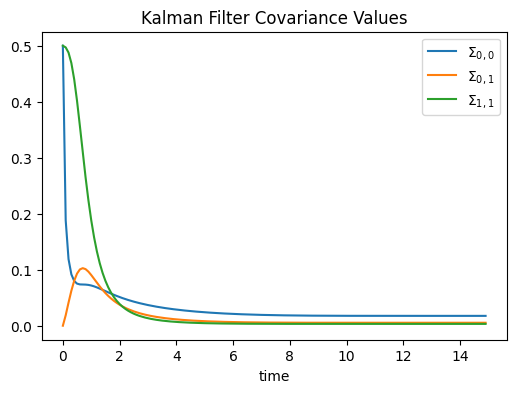

In [17]:
# Plot filter results

plt.figure(figsize=(8, 6))
plt.title("Kalman Filter State Estimates")
plt.xlabel("time")
plt.axhline(0, linestyle="--", color="gray", alpha=0.8)
plt.plot(timesteps, states_gt[:,0], label="$x_0$: position")
plt.plot(timesteps, states_gt[:,1], label="$x_1$: velocity")
plt.plot(timesteps, controls[:,0], label="$u$: acceleration")
plt.plot(timesteps, measurements[:,0], label="$z$: position measurement")
plt.plot(timesteps, means_KF[:,0], label="$\mu_0$: position estimate")
plt.plot(timesteps, means_KF[:,1], label="$\mu_1$: velocity estimate")
plt.legend()

plt.figure(figsize=(6, 4))
plt.title("Kalman Filter Covariance Values")
plt.xlabel("time")
plt.plot(timesteps, covariances_KF[:, 0, 0], label="$\Sigma_{0,0}$")
plt.plot(timesteps, covariances_KF[:, 0, 1], label="$\Sigma_{0,1}$")
plt.plot(timesteps, covariances_KF[:, 1, 1], label="$\Sigma_{1,1}$")
plt.legend()

## Error Analysis

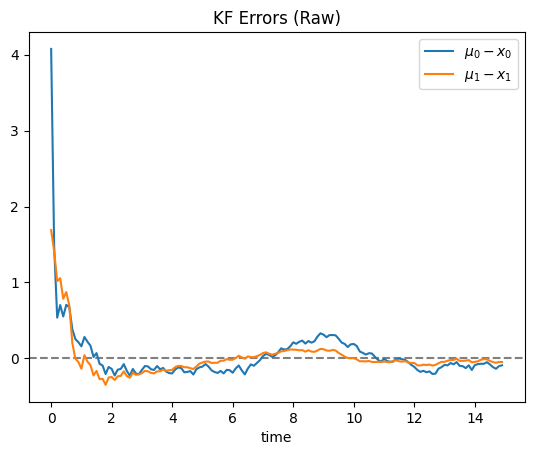

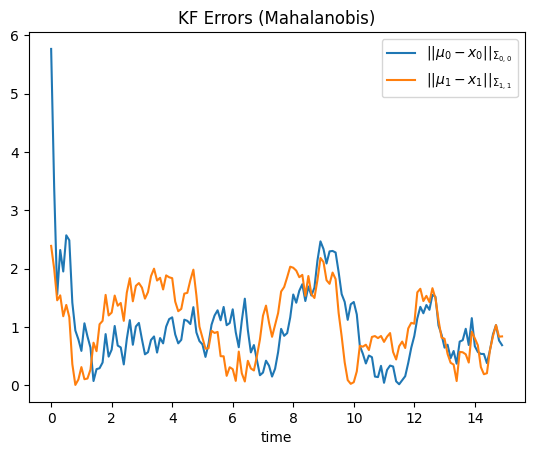

In [18]:
# Error analysis

from estimation_and_control.helpers import mahalanobis_distance

errors_KF = means_KF - states_gt
errors_KF_mahalanobis = np.array([
    [mahalanobis_distance(means_KF[t, i], states_gt[t, i], covariances_KF[t, [i], [i]])
     for i in range(car_system_gt.state_dim)]
    for t in range(T)
])

plt.figure()
plt.title("KF Errors (Raw)")
plt.xlabel("time")
plt.axhline(0, color="gray", linestyle="--")
plt.plot(timesteps, errors_KF[:, 0], label="$\mu_0 - x_0$")
plt.plot(timesteps, errors_KF[:, 1], label="$\mu_1 - x_1$")
plt.legend(loc="upper right")

plt.figure()
plt.title("KF Errors (Mahalanobis)")
plt.xlabel("time")
plt.plot(timesteps, errors_KF_mahalanobis[:, 0], label=r"$||\mu_0 - x_0 ||_{\Sigma_{0,0}}$")
plt.plot(timesteps, errors_KF_mahalanobis[:, 1], label=r"$||\mu_1 - x_1 ||_{\Sigma_{1,1}}$")
plt.legend(loc="upper right")